## Setup

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (
    Concatenate, Lambda, Dense, Dropout, Activation, Flatten, LSTM, SpatialDropout2D, Conv2D, MaxPooling2D,
    AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, BatchNormalization, ReLU, Input
)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import optimizers, regularizers, backend as K
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report,
    cohen_kappa_score, hamming_loss, log_loss, zero_one_loss, matthews_corrcoef, roc_curve, auc
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tensorflow.keras.utils import to_categorical, plot_model
from time import time
import time as tm
import datetime
from skimage.util.shape import view_as_blocks
import glob
import os
import random
import ntpath
import copy
from tensorflow import keras
from tensorflow.keras import layers

from tfkan.layers import DenseKAN

import mlflow
from mlflow.tensorflow import MlflowCallback

## Filters and Dataset 

In [12]:
################################################## 30 SRM FILTERS
srm_weights = np.load('../SRM_Kernels.npy') 
biasSRM=np.ones(30)
print (srm_weights.shape)
################################################## TLU ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################
def thtanh(x,t):
    th=K.tanh(x)*t
    return th

(5, 5, 1, 30)


S-UNIWARD BOSSbase 1.01 PAYLOAD = 0.4bpp

In [13]:
#Train
X_train = np.load('../data_gbras/X_train.npy')
y_train = np.load('../data_gbras/y_train.npy')
#Valid
X_valid = np.load('../data_gbras/X_valid.npy')
y_valid = np.load('../data_gbras/y_valid.npy')
#Test
X_test = np.load('../data_gbras/X_test.npy')
y_test = np.load('../data_gbras/y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(12000, 256, 256, 1)
(12000, 2)
(4000, 256, 256, 1)
(4000, 2)
(4000, 256, 256, 1)
(4000, 2)


## Functions arquitecture

In [14]:
def squeeze_excitation_layer(input_layer, out_dim, ratio, conv):
  squeeze = tf.keras.layers.GlobalAveragePooling2D()(input_layer)
  excitation = tf.keras.layers.Dense(units=out_dim / ratio, activation='relu')(squeeze)
  excitation = tf.keras.layers.Dense(out_dim,activation='sigmoid')(excitation)
  excitation = tf.reshape(excitation, [-1,1,1,out_dim])
  scale = tf.keras.layers.multiply([input_layer, excitation])
  if conv:
    shortcut = tf.keras.layers.Conv2D(out_dim,kernel_size=1,strides=1,
                                      padding='same',kernel_initializer='he_normal')(input_layer)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
  else:
    shortcut = input_layer
  out = tf.keras.layers.add([shortcut, scale])
  return out



def sreLu (input):
  return ReLU(negative_slope=0.1, threshold=0)(input)

def sConv(input,parameters,size,nstrides):
  return Conv2D(parameters, (size,size), strides=(nstrides,nstrides),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(input)

def sBN (input):
  return tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(input)

def sGlobal_Avg_Pooling (input):
  return tf.keras.layers.GlobalAveragePooling2D()(input)

def sDense (input, n_units, activate_c):
  return tf.keras.layers.Dense(n_units,activation=activate_c)(input)

def smultiply (input_1, input_2):
  return tf.keras.layers.multiply([input_1, input_2])

def sadd (input_1, input_2):
  return tf.keras.layers.add([input_1, input_2])

# Initial learning rate for the optimizer
initial_learning_rate = 0.001

# Learning rate schedule with exponential decay
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
  

### Blocks

In [15]:
def Block_1 (input, parameter):
  output = sConv(input, parameter, 3, 1)
  output = sBN(output)
  output = sreLu(output)
  return output
  


def SE_Block(input, out_dim, ratio):
  output = sGlobal_Avg_Pooling(input)
  output = sDense(output, out_dim/ratio, 'relu')
  output = sDense(output, out_dim, 'sigmoid')
  return output
  
  
  
def Block_2 (input, parameter):
  output = Block_1(input, parameter)
  output = sConv(output, parameter, 3, 1)
  output = sBN(output)
  multiplier = SE_Block(output,  parameter, parameter)
  # output = smultiply(output, output)
  output = smultiply(multiplier, output)
  output = sadd(output, input)
  return output
  
  

def Block_3 (input, parameter):
  addition = sConv(input, parameter, 1, 2)
  addition = sBN(addition)
  output = sConv(input, parameter, 3, 2)
  output = sBN(output)
  output = sreLu(output)
  output = sConv(output, parameter, 3, 1)
  output = sBN(output)
  multiplier = SE_Block(output,  parameter, parameter)
  output = smultiply(multiplier, output)
  output = sadd(output, addition)
  return output  
  
def Block_4 (input, parameter):
  output = Block_1(input, parameter)
  output = sConv(input, parameter, 3, 1)
  output = sBN(output)
  
  return output  

### Transformer

Hyperparameters 

In [6]:
# ViT ARCHITECTURE
LAYER_NORM_EPS_1 = 1e-6
PROJECTION_DIM_1 = 16
NUM_HEADS_1 = 4
NUM_LAYERS_1 = 4
MLP_UNITS_1 = [
    PROJECTION_DIM_1 * 2,
    PROJECTION_DIM_1,
]
# OPTIMIZER
LEARNING_RATE_2 = 1e-3
WEIGHT_DECAY_2 = 1e-4

IMAGE_SIZE_2 =  16# We will resize input images to this size.
PATCH_SIZE_2 = 4  # Size of the patches to be extracted from the input images.
NUM_PATCHES_2 = (IMAGE_SIZE_2 // PATCH_SIZE_2) ** 2
print(NUM_PATCHES_2)
# ViT ARCHITECTURE
LAYER_NORM_EPS_2 = 1e-6
PROJECTION_DIM_2 = 128
NUM_HEADS_2 = 4
NUM_LAYERS_2 = 4
MLP_UNITS_2 = [
    PROJECTION_DIM_2 * 2,
    PROJECTION_DIM_2
]


16


In [7]:
def position_embedding(projected_patches, num_patches=NUM_PATCHES_2, projection_dim=PROJECTION_DIM_2):
    # Build the positions: create a range of position indices from 0 to num_patches - 1
    positions = tf.range(start=0, limit=num_patches, delta=1)

    # Encode the positions with an Embedding layer
    encoded_positions = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )(positions)

    # Add encoded positions to the projected patches
    return projected_patches + encoded_positions

def mlp(x, dropout_rate, hidden_units):
    # Iterate over the hidden units and add Dense => Dropout layers
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)  # Dense layer with GELU activation
        x = layers.Dropout(dropout_rate)(x)  # Dropout layer
    return x

def transformer_2(encoded_patches):
    # Apply layer normalization
    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS_2)(encoded_patches)

    # Multi-Head Self Attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS_2, key_dim=PROJECTION_DIM_2, dropout=0.1
    )(x1, x1)

    # Skip connection
    x2 = layers.Add()([attention_output, encoded_patches])

    # Apply layer normalization again
    x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS_2)(x2)

    # Apply MLP layer
    x4 = mlp(x3, hidden_units=MLP_UNITS_2, dropout_rate=0.1)

    # Second skip connection
    encoded_patches = layers.Add()([x4, x2])
    return encoded_patches

def Transform_sh_2(inputs):
    # Apply squeeze and excitation layer
    inputs1 = squeeze_excitation_layer(inputs, out_dim=512, ratio=32.0, conv=False)
    print(inputs1.shape)

    # Project input patches using a Conv2D layer
    projected_patches = layers.Conv2D(
        filters=PROJECTION_DIM_2,
        kernel_size=(PATCH_SIZE_2, PATCH_SIZE_2),
        strides=(PATCH_SIZE_2, PATCH_SIZE_2),
        padding="VALID",
    )(inputs1)

    # Get the shape of the projected patches
    _, h, w, c = projected_patches.shape

    # Reshape the projected patches
    projected_patches = layers.Reshape((h * w, c))(projected_patches)  # (B, number_patches, projection_dim)

    # Add positional embeddings to the projected patches
    encoded_patches = position_embedding(projected_patches)  # (B, number_patches, projection_dim)

    # Apply dropout
    encoded_patches = layers.Dropout(0.1)(encoded_patches)

    # Iterate over the number of layers and stack transformer blocks
    for i in range(NUM_LAYERS_2):
        # Add a transformer block
        encoded_patches = transformer_2(encoded_patches)

    return encoded_patches

## Functions to training

In [8]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, initial_epoch = 0, model_name="", num_test=""):
    start_time = tm.time()
    log_dir="D:/testing_"+num_test+"/"+model_name+"_"+"{}".format(time())
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir)
    filepath = log_dir+"/saved-model.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1
    )
    model.reset_states()
    with mlflow.start_run() as run:
        history=model.fit(X_train, y_train, epochs=epochs, 
                            callbacks=[tensorboard,  checkpoint,
                                       MlflowCallback(run)], 
                            batch_size=batch_size,
                            validation_data=(X_valid, y_valid),
                            initial_epoch=initial_epoch)

        metrics = model.evaluate(X_test, y_test, verbose=0, callbacks=[MlflowCallback(run)])

    results_dir="D:/testing_"+num_test+"/"+model_name+"/"
   
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,1)
        #Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Accuracy Vs Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss Vs Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

## CVT-h2

In [9]:
def new_arch():
  tf.keras.backend.clear_session()
  inputs = tf.keras.Input(shape=(256,256,1), name="input_1")
  #Layer 1
  layers_ty = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), padding='same', trainable=False, activation=Tanh3, use_bias=True)(inputs)
  layers_tn = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), padding='same', trainable=True, activation=Tanh3, use_bias=True)(inputs)

  layers = tf.keras.layers.add([layers_ty, layers_tn])
  layers1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
  #Layer 2
  
  # L1
  layers = Block_1(layers1,64)

  # L2
  layers = Block_1(layers,64)

  # L3 - L7
  for i in range(5):
    layers = Block_2(layers,64)

  # L8 - L11
  for i in [64, 64, 128, 256]:
    layers = Block_3(layers,i)

  # L12
  layers = Block_4(layers,512)
  print('output last layer before transformer', layers.shape)
  #CVT=Transform_sh_1(layers)
  #CVT_2=Transform_sh_1(CVT)
  CVT1=Transform_sh_2(layers)

  representation = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS_2)(CVT1)
  representation = tf.keras.layers.GlobalAvgPool1D()(representation)
  #---------------------------------------------------Fin de Transformer 2------------------------------------------------------------------------#
  # Classify outputs.
      #FC
  layers = Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(representation)
  layers = ReLU(negative_slope=0.1, threshold=0)(layers)
  layers = Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
  layers = ReLU(negative_slope=0.1, threshold=0)(layers)
  layers = Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
  layers = ReLU(negative_slope=0.1, threshold=0)(layers)

  #Softmax
  predictions = Dense(2, activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
  model =tf.keras.Model(inputs = inputs, outputs=predictions)
 
  # Compile the model if the compile flag is set

  optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.95)
  if compile:
      model.compile(optimizer= optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
      
      print ("Transformer_create")

  return model


model = new_arch()  
  

output last layer before transformer (None, 16, 16, 512)
(None, 16, 16, 512)
Transformer_create


## Training

In [10]:
base_name="04S-UNIWARD"
name="Model_"+'CVT_prueba1'+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=8, epochs=800, model_name=name, num_test='1_cvt')

Epoch 1/800
1500/1500 [==============================] - ETA: 0s - loss: 0.9567 - accuracy: 0.4864
Epoch 1: val_accuracy improved from -inf to 0.50225, saving model to D:/testing_1_cvt/Model_CVT_prueba1_04S-UNIWARD_1729515488.1369982\saved-model.hdf5
1500/1500 [==============================] - 719s 471ms/step - loss: 0.9567 - accuracy: 0.4864 - val_loss: 0.9519 - val_accuracy: 0.5023
Epoch 2/800
1500/1500 [==============================] - ETA: 0s - loss: 0.9508 - accuracy: 0.4990
Epoch 2: val_accuracy improved from 0.50225 to 0.53375, saving model to D:/testing_1_cvt/Model_CVT_prueba1_04S-UNIWARD_1729515488.1369982\saved-model.hdf5
1500/1500 [==============================] - 725s 483ms/step - loss: 0.9508 - accuracy: 0.4990 - val_loss: 0.9438 - val_accuracy: 0.5337
Epoch 3/800
1500/1500 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.5309
Epoch 3: val_accuracy improved from 0.53375 to 0.55350, saving model to D:/testing_1_cvt/Model_CVT_prueba1_04S-UNIWARD_172

ValueError: Data cardinality is ambiguous:
  x sizes: 6000
  y sizes: 4000
Make sure all arrays contain the same number of samples.

## CVKAN

In [23]:
def new_arch_kan():
  tf.keras.backend.clear_session()
  inputs = tf.keras.Input(shape=(256,256,1), name="input_1")
  #Layer 1
  layers_ty = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), padding='same', trainable=False, activation=Tanh3, use_bias=True)(inputs)
  layers_tn = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), padding='same', trainable=True, activation=Tanh3, use_bias=True)(inputs)

  layers = tf.keras.layers.add([layers_ty, layers_tn])
  layers1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
  #Layer 2
  
  # L1
  layers = Block_1(layers1,64)

  # L2
  layers = Block_1(layers,64)

  # L3 - L7
  for i in range(5):
    layers = Block_2(layers,64)

  # L8 - L11
  for i in [64, 64, 128, 256]:
    layers = Block_3(layers,i)

  # L12
  layers = Block_4(layers,512)
  #CVT=Transform_sh_1(layers)

  representation = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS_2)(layers)
  representation = tf.keras.layers.GlobalAvgPool2D()(representation)
  #---------------------------------------------------Fin de Transformer 2------------------------------------------------------------------------#
  # Classify outputs.
      #FC
  layers = DenseKAN(64)(representation)
  layers = DenseKAN(32)(layers)
  layers = DenseKAN(16)(layers)

  #Softmax
  layers = DenseKAN(2)(layers)
  predictions = tf.keras.layers.Softmax(axis=1)(layers)
  model =tf.keras.Model(inputs = inputs, outputs=predictions)

  # Compile the model if the compile flag is set
  if compile:
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

      print("kan_create")

  return model


model2 = new_arch_kan()  
  

kan_create


## Training

Epoch 1/400
3000/3000 [==============================] - ETA: 0s - loss: 0.7960 - accuracy: 0.5032
Epoch 1: val_accuracy improved from -inf to 0.50200, saving model to D:/testing_2_kan/Model_CVkan_prueba1_04S-UNIWARD_1729988110.3461075\saved-model.hdf5
3000/3000 [==============================] - 466s 153ms/step - loss: 0.7960 - accuracy: 0.5032 - val_loss: 0.7640 - val_accuracy: 0.5020
Epoch 2/400
3000/3000 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.4967
Epoch 2: val_accuracy did not improve from 0.50200
3000/3000 [==============================] - 444s 148ms/step - loss: 0.7195 - accuracy: 0.4967 - val_loss: 0.7247 - val_accuracy: 0.5008
Epoch 3/400
3000/3000 [==============================] - ETA: 0s - loss: 0.7190 - accuracy: 0.5008
Epoch 3: val_accuracy improved from 0.50200 to 0.50300, saving model to D:/testing_2_kan/Model_CVkan_prueba1_04S-UNIWARD_1729988110.3461075\saved-model.hdf5
3000/3000 [==============================] - 450s 150ms/step - loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


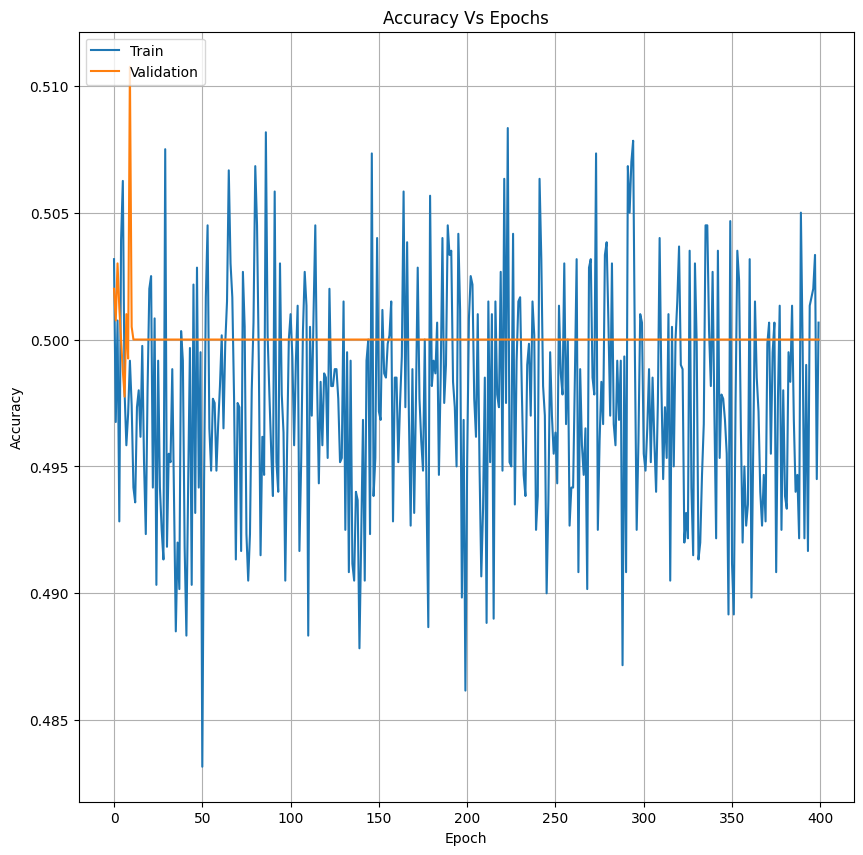

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


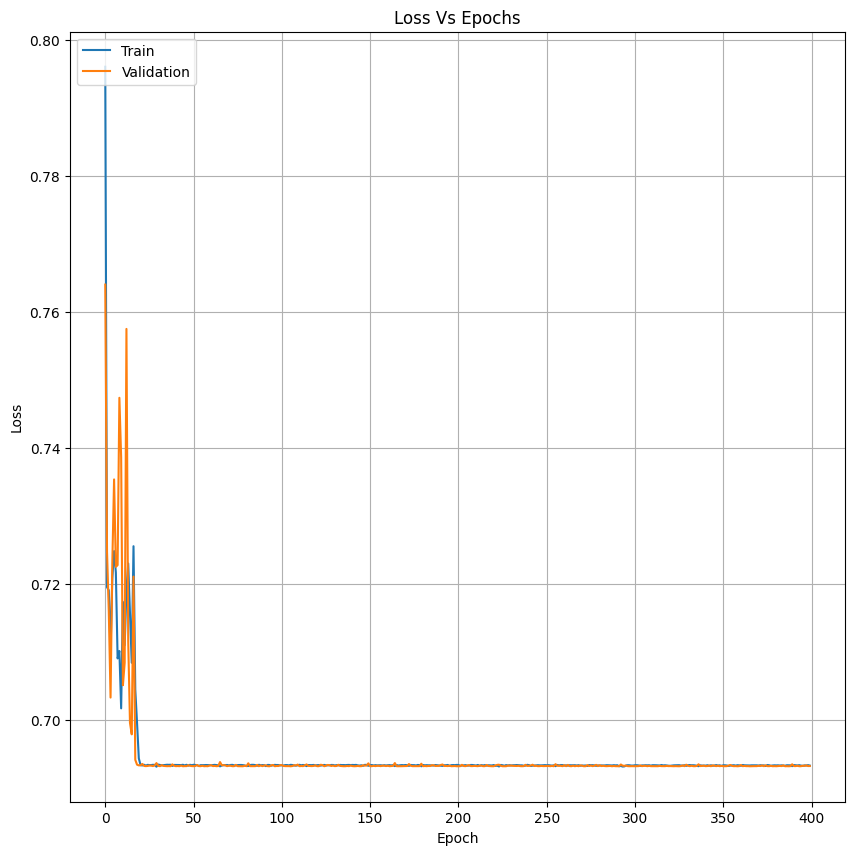

Time Model_CVkan_prueba1_04S-UNIWARD = 175502.6486272812 [seconds]


In [25]:
base_name="04S-UNIWARD"
name="Model_"+'CVkan_prueba1'+"_"+base_name
_, history  = train(model2, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=4, epochs=400, model_name=name, num_test='2_kan')